<a href="https://colab.research.google.com/github/kevinbui0410/Coursera_Capstone/blob/main/Chilliwack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Collect data from wiki and Chillwack open data => Data Frame contain Chilliwack neighbourhoods, latitude, longitude**

**Getting neighborhood geo location from https://www.chilliwack.com/main/page.cfm?id=2331&odAction=viewItem&odID=154**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns


# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
pip install geopandas

     |████████████████████████████████| 972kB 5.5MB/s 
     |████████████████████████████████| 6.5MB 11.5MB/s 
     |████████████████████████████████| 14.8MB 302kB/s 


In [3]:
import geopandas as gpd
ds_geo = gpd.read_file('http://www.kevin-bui.com/chilliwack/Neighbourhoods.JSON',orient='values')
print(ds_geo.head())

                NAME                                           geometry
0  Chilliwack Proper  POLYGON ((-121.93030 49.18599, -121.93037 49.1...
1           Rosedale  POLYGON ((-121.79852 49.18495, -121.79840 49.1...
2    Sardis - Vedder  POLYGON ((-121.96565 49.12280, -121.96608 49.1...
3             Yarrow  POLYGON ((-122.06512 49.08816, -122.06519 49.0...
4       Village West  POLYGON ((-121.98166 49.15912, -121.98187 49.1...


In [4]:
ds_geo['longitude'] = ds_geo['geometry'].centroid.apply(lambda p: p.x)
ds_geo['latitude'] = ds_geo['geometry'].centroid.apply(lambda p: p.y)
ds_geo['area'] = ds_geo['geometry'].area
ds_geo.head()

,NAME,geometry,longitude,latitude,area
0,Chilliwack Proper,"POLYGON ((-121.93030 49.18599, -121.93037 49.1...",-121.944413,49.172067,0.001731
1,Rosedale,"POLYGON ((-121.79852 49.18495, -121.79840 49.1...",-121.810642,49.178429,0.000091
2,Sardis - Vedder,"POLYGON ((-121.96565 49.12280, -121.96608 49.1...",-121.966648,49.118807,0.001219
3,Yarrow,"POLYGON ((-122.06512 49.08816, -122.06519 49.0...",-122.054833,49.083813,0.000204
4,Village West,"POLYGON ((-121.98166 49.15912, -121.98187 49.1...",-121.996555,49.149808,0.000440


Text(0.5, 1.0, 'Neighborhood Areas')

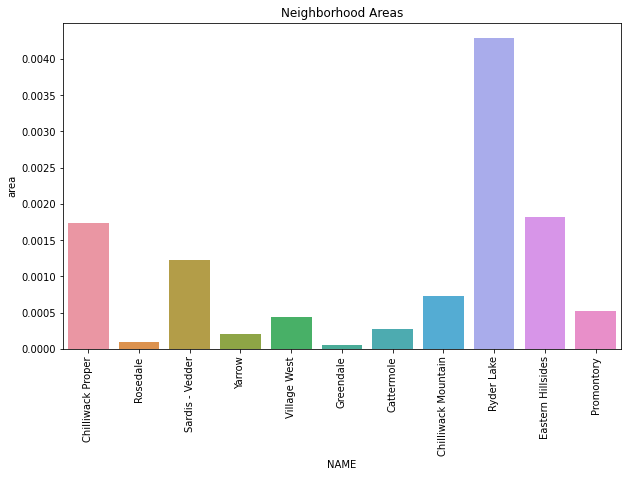

In [5]:
plt.figure(figsize=(10,6))
# plt.barh(data=ds_geo,y='NAME',width='area')
sns.barplot(data=ds_geo,x='NAME',y='area')
plt.xticks(rotation=90)
plt.title('Neighborhood Areas')

In [6]:
ds_geo.shape

(11, 5)

**Create a map of Chilliwack with neighborhoods superimposed on top.**

In [7]:
address = 'Chilliwack'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chilliwack City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chilliwack City are 49.157677, -121.9514307.


In [8]:
# create map of Chilliwack using latitude and longitude values
map_chilliwack = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(ds_geo['latitude'], ds_geo['longitude'], ds_geo['NAME']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chilliwack)  
    
map_chilliwack

# Segment and Cluster neighborhoods based on Foursquare Food Data
**Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.**

In [9]:
CLIENT_ID = 'ZJ24NYCNKYADQGHBVBEC510DD5BEJ4BYHEJCGJDYWBDWJMOJ' # your Foursquare ID
CLIENT_SECRET = 'SKFFJMYTI1145TQMWOAHHBLMROWHF4BRT0ME42UYP0CDAIY1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZJ24NYCNKYADQGHBVBEC510DD5BEJ4BYHEJCGJDYWBDWJMOJ
CLIENT_SECRET:SKFFJMYTI1145TQMWOAHHBLMROWHF4BRT0ME42UYP0CDAIY1


Get the first neighborhood info

In [10]:
neighborhood_latitude = ds_geo.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = ds_geo.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = ds_geo.loc[0, 'NAME'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Chilliwack Proper are 49.172066790953444, -121.94441304243111.


**Now, let's get the top 100 venues that are in Chilliwack Proper within a radius of 500 meters.**

Setup API

In [11]:
LIMIT = 100
radius = 500
categoryID = '4d4b7105d754a06374d81259' # search for food category only

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
    categoryID)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ZJ24NYCNKYADQGHBVBEC510DD5BEJ4BYHEJCGJDYWBDWJMOJ&client_secret=SKFFJMYTI1145TQMWOAHHBLMROWHF4BRT0ME42UYP0CDAIY1&v=20180605&ll=49.172066790953444,-121.94441304243111&radius=500&limit=100&categoryId=4d4b7105d754a06374d81259'

Call API to get data

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fe1a8bb79763a1bc4cc547c'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4d549103cc65a14318c3435e-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d16e941735',
         'name': 'Fast Food Restaurant',
         'pluralName': 'Fast Food Restaurants',
         'primary': True,
         'shortName': 'Fast Food'}],
       'id': '4d549103cc65a14318c3435e',
       'location': {'address': '45843 Yale Road West',
        'cc': 'CA',
        'city': 'Chilliwack',
        'country': 'Canada',
        'distance': 483,
        'formattedAddress': ['45843 Yale Road West',
         'Chilliwack BC V2P 2M4',
         'Canada'],
        'labeledLatLngs': [{'label': 'display',

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**Get venue list from return data**

In [14]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,KFC,Fast Food Restaurant,49.171500,-121.951000
1,Clark's,Restaurant,49.173073,-121.946410
2,Bravo Restaurant & Lounge,Restaurant,49.171466,-121.949778
3,Chilies Thai Restaurant,Thai Restaurant,49.171570,-121.949964


**Apply to get for all chilliwack neighborhoods**

In [15]:
def getNearbyVenues(names, latitudes, longitudes, categoryID = '4d4b7105d754a06374d81259', radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT,
            categoryID)
            
        # make the GET request       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
chilliwack_venues = getNearbyVenues(names=ds_geo['NAME'],
                                   latitudes=ds_geo['latitude'],
                                   longitudes=ds_geo['longitude']
                                  )

Chilliwack Proper
Rosedale
Sardis - Vedder
Yarrow
Village West
Greendale
Cattermole
Chilliwack Mountain
Ryder Lake
Eastern Hillsides
Promontory


**Let's check the size of the resulting dataframe**

In [17]:
print(chilliwack_venues.shape)
chilliwack_venues.head()

(12, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chilliwack Proper,49.172067,-121.944413,KFC,49.171500,-121.951000,Fast Food Restaurant
1,Chilliwack Proper,49.172067,-121.944413,Clark's,49.173073,-121.946410,Restaurant
2,Chilliwack Proper,49.172067,-121.944413,Bravo Restaurant & Lounge,49.171466,-121.949778,Restaurant
3,Chilliwack Proper,49.172067,-121.944413,Chilies Thai Restaurant,49.171570,-121.949964,Thai Restaurant
4,Sardis - Vedder,49.118807,-121.966648,Fig Guy Keith Wilson,49.119464,-121.972118,Food


**Let's check how many venues were returned for each neighborhood**

In [18]:
chilliwack_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Chilliwack Proper,4,4,4,4,4,4
Promontory,2,2,2,2,2,2
Sardis - Vedder,1,1,1,1,1,1
Village West,1,1,1,1,1,1
Yarrow,4,4,4,4,4,4


**Let's find out how many unique categories can be curated from all the returned venues**

In [19]:
print('There are {} uniques categories.'.format(len(chilliwack_venues['Venue Category'].unique())))

There are 9 uniques categories.


### Analyze Each Neighborhood


In [20]:
# one hot encoding
chilliwack_onehot = pd.get_dummies(chilliwack_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chilliwack_onehot['Neighborhood'] = chilliwack_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chilliwack_onehot.columns[-1]] + list(chilliwack_onehot.columns[:-1])
chilliwack_onehot = chilliwack_onehot[fixed_columns]

chilliwack_onehot.head()

,Neighborhood,Bakery,Breakfast Spot,Deli / Bodega,Fast Food Restaurant,Food,Pizza Place,Restaurant,Taco Place,Thai Restaurant
0,Chilliwack Proper,0,0,0,1,0,0,0,0,0
1,Chilliwack Proper,0,0,0,0,0,0,1,0,0
2,Chilliwack Proper,0,0,0,0,0,0,1,0,0
3,Chilliwack Proper,0,0,0,0,0,0,0,0,1
4,Sardis - Vedder,0,0,0,0,1,0,0,0,0


In [21]:
chilliwack_onehot.shape

(12, 10)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
chilliwack_grouped = chilliwack_onehot.groupby('Neighborhood').sum().reset_index()
chilliwack_grouped

,Neighborhood,Bakery,Breakfast Spot,Deli / Bodega,Fast Food Restaurant,Food,Pizza Place,Restaurant,Taco Place,Thai Restaurant
0,Chilliwack Proper,0,0,0,1,0,0,2,0,1
1,Promontory,0,0,1,0,0,1,0,0,0
2,Sardis - Vedder,0,0,0,0,1,0,0,0,0
3,Village West,0,0,0,0,0,0,1,0,0
4,Yarrow,1,1,1,0,0,0,0,1,0


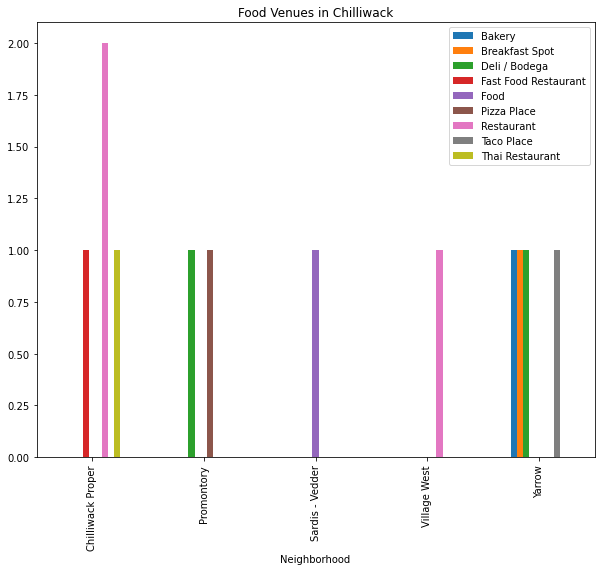

In [23]:
chilliwack_grouped.plot.bar(x='Neighborhood',figsize=(10,8), title='Food Venues in Chilliwack')

**Check size**

In [24]:
chilliwack_grouped.shape

(5, 10)

**Let's print each neighborhood along with the top 5 most common venues**

In [25]:
num_top_venues = 5

for hood in chilliwack_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = chilliwack_grouped[chilliwack_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Chilliwack Proper----
                  venue  freq
0            Restaurant   2.0
1  Fast Food Restaurant   1.0
2       Thai Restaurant   1.0
3                Bakery   0.0
4        Breakfast Spot   0.0


----Promontory----
                  venue  freq
0         Deli / Bodega   1.0
1           Pizza Place   1.0
2                Bakery   0.0
3        Breakfast Spot   0.0
4  Fast Food Restaurant   0.0


----Sardis - Vedder----
                  venue  freq
0                  Food   1.0
1                Bakery   0.0
2        Breakfast Spot   0.0
3         Deli / Bodega   0.0
4  Fast Food Restaurant   0.0


----Village West----
                  venue  freq
0            Restaurant   1.0
1                Bakery   0.0
2        Breakfast Spot   0.0
3         Deli / Bodega   0.0
4  Fast Food Restaurant   0.0


----Yarrow----
                  venue  freq
0                Bakery   1.0
1        Breakfast Spot   1.0
2         Deli / Bodega   1.0
3            Taco Place   1.0
4  Fast Food Rest

**Put into a pandas dataframe**

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Create dataframe and display top 10 venues for each neighborhood**

In [28]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chilliwack_grouped['Neighborhood']

for ind in np.arange(chilliwack_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chilliwack_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Chilliwack Proper,Restaurant,Thai Restaurant,Fast Food Restaurant,Taco Place,Pizza Place
1,Promontory,Pizza Place,Deli / Bodega,Thai Restaurant,Taco Place,Restaurant
2,Sardis - Vedder,Food,Thai Restaurant,Taco Place,Restaurant,Pizza Place
3,Village West,Restaurant,Thai Restaurant,Taco Place,Pizza Place,Food
4,Yarrow,Taco Place,Deli / Bodega,Breakfast Spot,Bakery,Thai Restaurant


### Clustering Neighborhoods

**Using k_means to cluster**

In [29]:
# set number of clusters
kclusters = 3

chilliwack_grouped_clustering = chilliwack_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chilliwack_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chilliwack_merged = ds_geo

# merge chilliwack_grouped with chilliwack_data to add latitude/longitude for each neighborhood
chilliwack_merged = chilliwack_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='NAME')

chilliwack_merged.head() # check the last columns!

,NAME,geometry,longitude,latitude,area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Chilliwack Proper,"POLYGON ((-121.93030 49.18599, -121.93037 49.1...",-121.944413,49.172067,0.001731,1.0,Restaurant,Thai Restaurant,Fast Food Restaurant,Taco Place,Pizza Place
1,Rosedale,"POLYGON ((-121.79852 49.18495, -121.79840 49.1...",-121.810642,49.178429,0.000091,NaN,NaN,NaN,NaN,NaN,NaN
2,Sardis - Vedder,"POLYGON ((-121.96565 49.12280, -121.96608 49.1...",-121.966648,49.118807,0.001219,2.0,Food,Thai Restaurant,Taco Place,Restaurant,Pizza Place
3,Yarrow,"POLYGON ((-122.06512 49.08816, -122.06519 49.0...",-122.054833,49.083813,0.000204,0.0,Taco Place,Deli / Bodega,Breakfast Spot,Bakery,Thai Restaurant
4,Village West,"POLYGON ((-121.98166 49.15912, -121.98187 49.1...",-121.996555,49.149808,0.000440,2.0,Restaurant,Thai Restaurant,Taco Place,Pizza Place,Food


Finally, let's visualize the resulting clusters

In [31]:
chilliwack_merged.dropna(inplace=True)

In [32]:
chilliwack_merged=chilliwack_merged.astype({'Cluster Labels': 'int32'})

In [33]:
chilliwack_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5 entries, 0 to 10
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   NAME                   5 non-null      object  
 1   geometry               5 non-null      geometry
 2   longitude              5 non-null      float64 
 3   latitude               5 non-null      float64 
 4   area                   5 non-null      float64 
 5   Cluster Labels         5 non-null      int32   
 6   1st Most Common Venue  5 non-null      object  
 7   2nd Most Common Venue  5 non-null      object  
 8   3rd Most Common Venue  5 non-null      object  
 9   4th Most Common Venue  5 non-null      object  
 10  5th Most Common Venue  5 non-null      object  
dtypes: float64(3), geometry(1), int32(1), object(6)
memory usage: 460.0+ bytes


In [34]:
chilliwack_merged

,NAME,geometry,longitude,latitude,area,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Chilliwack Proper,"POLYGON ((-121.93030 49.18599, -121.93037 49.1...",-121.944413,49.172067,0.001731,1,Restaurant,Thai Restaurant,Fast Food Restaurant,Taco Place,Pizza Place
2,Sardis - Vedder,"POLYGON ((-121.96565 49.12280, -121.96608 49.1...",-121.966648,49.118807,0.001219,2,Food,Thai Restaurant,Taco Place,Restaurant,Pizza Place
3,Yarrow,"POLYGON ((-122.06512 49.08816, -122.06519 49.0...",-122.054833,49.083813,0.000204,0,Taco Place,Deli / Bodega,Breakfast Spot,Bakery,Thai Restaurant
4,Village West,"POLYGON ((-121.98166 49.15912, -121.98187 49.1...",-121.996555,49.149808,0.000440,2,Restaurant,Thai Restaurant,Taco Place,Pizza Place,Food
10,Promontory,"POLYGON ((-121.90849 49.11528, -121.90847 49.1...",-121.933184,49.104136,0.000518,2,Pizza Place,Deli / Bodega,Thai Restaurant,Taco Place,Restaurant


In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chilliwack_merged['latitude'], chilliwack_merged['longitude'], chilliwack_merged['NAME'], chilliwack_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

**Cluster 1**

In [36]:
chilliwack_merged.loc[chilliwack_merged['Cluster Labels'] == 0, chilliwack_merged.columns[[0] + list(range(5, chilliwack_merged.shape[1]))]]

,NAME,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Yarrow,0,Taco Place,Deli / Bodega,Breakfast Spot,Bakery,Thai Restaurant


**Cluster 2**

In [37]:
chilliwack_merged.loc[chilliwack_merged['Cluster Labels'] == 1, chilliwack_merged.columns[[0] + list(range(5, chilliwack_merged.shape[1]))]]

,NAME,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Chilliwack Proper,1,Restaurant,Thai Restaurant,Fast Food Restaurant,Taco Place,Pizza Place


**Cluster 3**

In [38]:
chilliwack_merged.loc[chilliwack_merged['Cluster Labels'] == 2, chilliwack_merged.columns[[0] + list(range(5, chilliwack_merged.shape[1]))]]

,NAME,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Sardis - Vedder,2,Food,Thai Restaurant,Taco Place,Restaurant,Pizza Place
4,Village West,2,Restaurant,Thai Restaurant,Taco Place,Pizza Place,Food
10,Promontory,2,Pizza Place,Deli / Bodega,Thai Restaurant,Taco Place,Restaurant


# Schools Analysis
**Collect school information and explore them**

In [39]:
ds_school = gpd.read_file('http://www.kevin-bui.com/chilliwack/Schools.JSON',orient='values')
ds_school.head()

,SCHOOL_NAME,geometry
0,Sto:lo Alternate School,"POLYGON ((-121.96362 49.13426, -121.96360 49.1..."
1,Timothy Christian,"POLYGON ((-121.83059 49.19071, -121.83066 49.1..."
2,Strathcona Elementary,"POLYGON ((-121.94079 49.18946, -121.94162 49.1..."
3,Little Mountain Elementary,"POLYGON ((-121.92789 49.18264, -121.92859 49.1..."
4,Cheam Elementary,"POLYGON ((-121.89359 49.18194, -121.89437 49.1..."


In [40]:
ds_school['longitude'] = ds_school['geometry'].centroid.apply(lambda p: p.x)
ds_school['latitude'] = ds_school['geometry'].centroid.apply(lambda p: p.y)
ds_school['area'] = ds_school['geometry'].area
ds_school.head()

,SCHOOL_NAME,geometry,longitude,latitude,area
0,Sto:lo Alternate School,"POLYGON ((-121.96362 49.13426, -121.96360 49.1...",-121.964041,49.134613,5.908694e-07
1,Timothy Christian,"POLYGON ((-121.83059 49.19071, -121.83066 49.1...",-121.829021,49.189716,6.234668e-06
2,Strathcona Elementary,"POLYGON ((-121.94079 49.18946, -121.94162 49.1...",-121.940824,49.187967,3.060395e-06
3,Little Mountain Elementary,"POLYGON ((-121.92789 49.18264, -121.92859 49.1...",-121.929212,49.181726,4.478329e-06
4,Cheam Elementary,"POLYGON ((-121.89359 49.18194, -121.89437 49.1...",-121.893959,49.181643,5.040842e-07


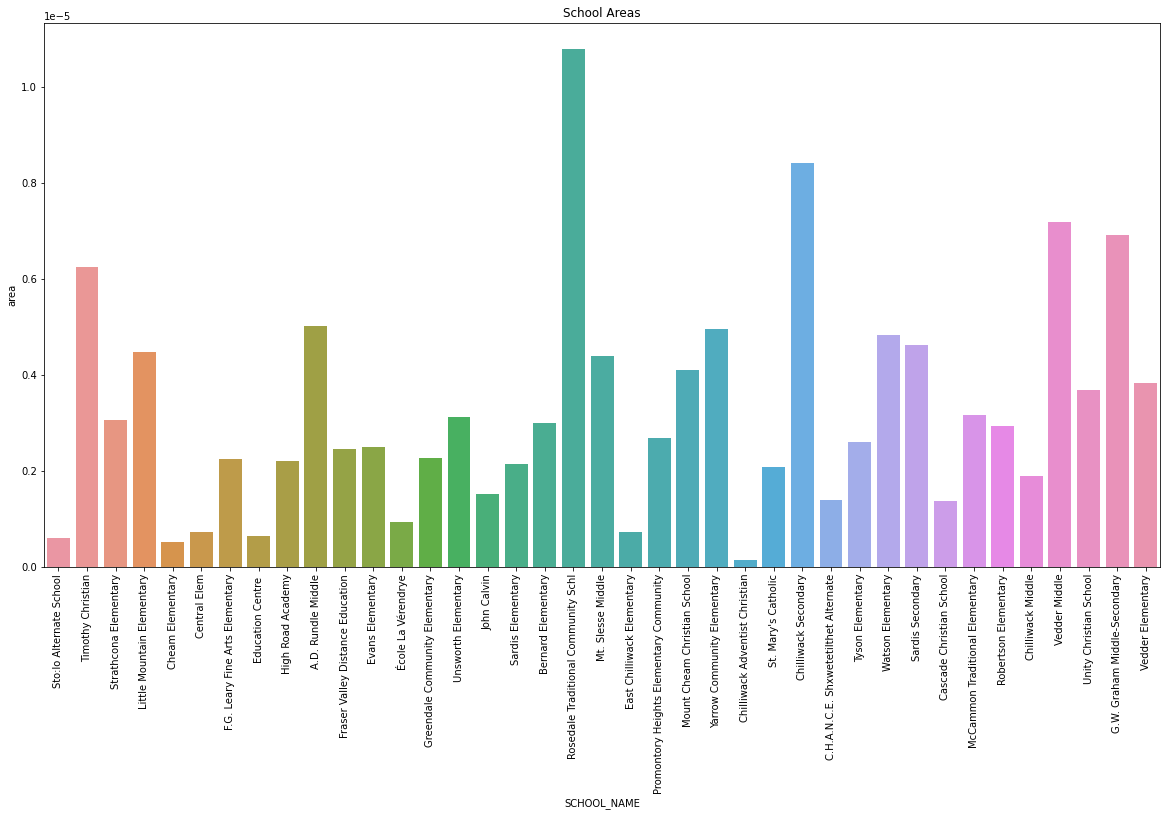

In [41]:
plt.figure(figsize=(20,10))
# plt.bar(data=ds_school,x='SCHOOL_NAME',height='area')
plt.title('School Areas')
plt.xticks(rotation=90)
sns.barplot(data=ds_school,x='SCHOOL_NAME',y='area')

**Create a map of Chilliwack with schools superimposed on top.**

In [42]:
address = 'Chilliwack'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chilliwack City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chilliwack City are 49.157677, -121.9514307.


In [43]:
# create map of Chilliwack using latitude and longitude values
map_school_chilliwack = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(ds_school['latitude'], ds_school['longitude'], ds_school['SCHOOL_NAME']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_school_chilliwack)  
    
map_school_chilliwack

In [44]:
chilliwack_schools = getNearbyVenues(names=ds_geo['NAME'],
                                   latitudes=ds_geo['latitude'],
                                   longitudes=ds_geo['longitude'],
                                   categoryID='4bf58dd8d48988d13b941735'
                                  )

Chilliwack Proper
Rosedale
Sardis - Vedder
Yarrow
Village West
Greendale
Cattermole
Chilliwack Mountain
Ryder Lake
Eastern Hillsides
Promontory


In [45]:
chilliwack_schools.shape

(3, 7)

In [46]:
chilliwack_schools.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chilliwack Proper,49.172067,-121.944413,Chilliwack Senior Secondary School,49.174939,-121.943110,High School
1,Sardis - Vedder,49.118807,-121.966648,Vedder Middle School,49.117895,-121.964202,High School
2,Sardis - Vedder,49.118807,-121.966648,Sardis Secondary School,49.122155,-121.967356,High School
